# Variable Neighborhood Search (VNS) for TSP

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

## VNS Class

In [2]:
class VNS:
    def __init__(self, cities):
        self.cities = cities
        self.distance_matrix = self.calculate_distance_matrix()
        self.best_distance_history = [] 
        self.local_search_iterations = [] 
        self.improved_local_search_iterations = [] 
    
    def calculate_distance_matrix(self):
        num_cities = len(self.cities)
        matrix = np.zeros((num_cities, num_cities))
        for i in range(num_cities):
            for j in range(num_cities):
                matrix[i, j] = np.linalg.norm(self.cities[i] - self.cities[j])
        return matrix
    
    def calculate_distance(self, index1, index2):
        return self.distance_matrix[index1, index2]
    
    def total_distance(self, solution):
        distance = 0
        for i in range(len(solution)):
            distance += self.calculate_distance(solution[i], solution[(i + 1) % len(solution)])
        return distance
    
    @staticmethod
    def generate_initial_solution(num_cities):
        return np.random.permutation(num_cities)
    
    @staticmethod
    def shake(solution):
        n = len(solution)
        i, j = np.random.choice(range(n), size=2, replace=False)
        solution[i], solution[j] = solution[j], solution[i]
        return solution
    
    def local_search(self, solution):
        improved = True
        total_counter = 0
        improved_counter = 0
        while improved:
            improved = False
            for i in range(len(solution) - 1):
                for j in range(i + 2, len(solution)):  # Ensure segments do not overlap
                    # Calculate the difference in distance if we were to perform the swap
                    old_dist = self.calculate_distance(solution[i], solution[i + 1]) + \
                            self.calculate_distance(solution[j - 1], solution[j % len(solution)])
                    new_dist = self.calculate_distance(solution[i], solution[j - 1]) + \
                            self.calculate_distance(solution[i + 1], solution[j % len(solution)])
                    total_counter += 1
                    # If the new distance is shorter, perform the swap and mark an improvement
                    if new_dist < old_dist:
                        solution[i + 1:j] = solution[i + 1:j][::-1]  # This is the 2-opt swap
                        improved = True
                        improved_counter += 1
                        break  # Exit the inner loop to restart the search from the beginning
                if improved:
                    break  # Restart the outer loop if improvement was found

        self.local_search_iterations.append(total_counter)
        self.improved_local_search_iterations.append(improved_counter)
        return solution

    
    def run(self, max_iterations, k_max):
        n = len(self.cities)
        best_solution = self.generate_initial_solution(n)
        best_distance = self.total_distance(best_solution)

        k = 1
        iteration = 0
        while iteration < max_iterations:
            new_solution = self.shake(best_solution.copy())
            new_solution = self.local_search(new_solution)
            new_distance = self.total_distance(new_solution)

            if new_distance < best_distance:
                best_solution = new_solution
                best_distance = new_distance
                k = 1
            else:
                k += 1

            if k > k_max:
                k = 1
                iteration += 1
            
            # Record best distance for this iteration
            self.best_distance_history.append(best_distance)

        return best_solution, best_distance
    
    @staticmethod
    def plot_solution(solution, cities):
        plt.figure(figsize=(8, 6))
        plt.plot(cities[:, 0], cities[:, 1], 'o', markersize=8, color='blue')
        plt.plot(cities[solution, 0], cities[solution, 1], 'r-', linewidth=2)
        plt.plot([cities[solution[-1], 0], cities[solution[0], 0]],
                 [cities[solution[-1], 1], cities[solution[0], 1]], 'r-', linewidth=2) 
        plt.title('TSP Solution')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()

    def plot_progress(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_distance_history, marker='o', linestyle='-', markersize=5)
        plt.title('VNS Algorithm Progress Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Best Distance Found')
        plt.grid(True)
        plt.show()


## Reading and Preparing Data

In [3]:

def read_tsp_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        while True:
            line = file.readline()
            if line.strip() == 'NODE_COORD_SECTION':
                break
        for line in file:
            if line.strip() == 'EOF':
                break
            _, x, y = line.strip().split()
            coordinates.append([float(x), float(y)])
    return np.array(coordinates)
        

## Main Execution

Best solution: [137 138 153 156 152 149 143 140 151 146 150 154 161 157 158 164 167 166
 169 170 165 159 147 142 135 130 128 134 132 127 123 122 119 120 116 115
 114 111 109  99 107 106 104 105 117 121 118 113 112 108 101 102  90  92
  95  94  96  91  87  82  78  80  83  76  69  63  67  65  72  66  60  50
  46  38  33  39  42  57  55  52  51  53  54  48  49  41  43  45  47  40
  37  34  30  31  29  18  14  11   9   8   4   2   1   3   0   5   7  15
  12  22  24  13  10   6  16  25  23  20  17  32  27  28  21  26  36  44
  56  59  68  73  71  77  74  75  86  79  70  81  61  58  35  62  19  64
  84  85  97  89  88  93  98 100 103 110 129 126 124 125 131 133 136 139
 141 145 148 144 155 160 162 163 168 175 181 171 178 173 172 174 182 185
 186 193 189 191 190 188 187 183 176 180 177 179 184 192]
Total distance: 9590.603637186692
Execution time: 50.96603512763977 seconds


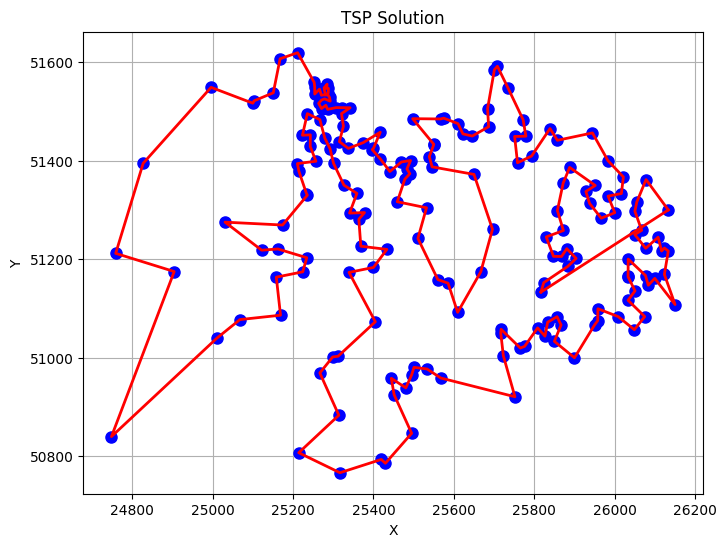

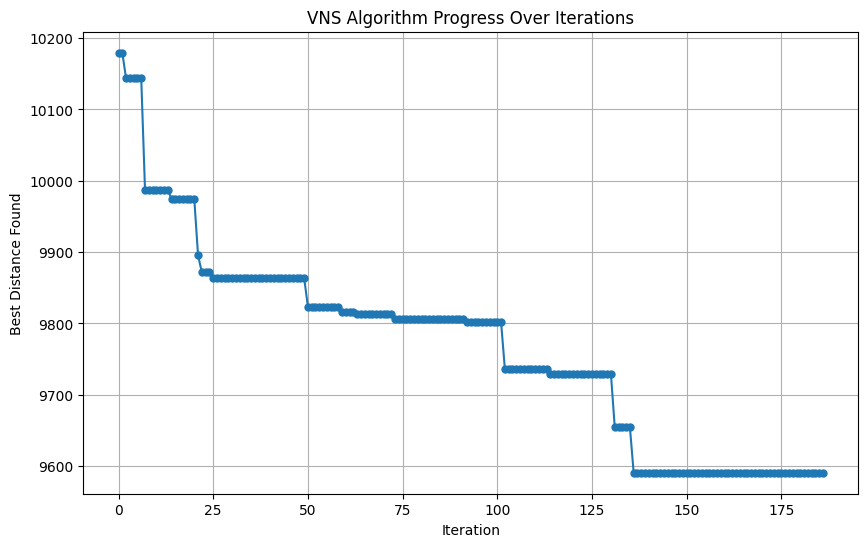

In [26]:

np.random.seed(41)

file_name = 'qa194.tsp'
cities = read_tsp_file(file_name)

# Start measuring time
start_time = time.time()

vns = VNS(cities)
best_solution, best_distance = vns.run(max_iterations=10, k_max=10)

# Measure the execution time
end_time = time.time()
duration = end_time - start_time

print('Best solution:', best_solution)
print('Total distance:', best_distance)
print(f"Execution time: {duration} seconds")
vns.plot_solution(best_solution, cities)
vns.plot_progress()
        

# Calculations for variable iterations and Kmax

In [5]:
import numpy as np
import time

# Parameters
iterations = [1, 2, 3, 4, 5, 6]
k_max_values = [1, 2, 3, 4, 5, 6]
results = []

tries = 5

# Initialize data structure to store all distances
all_distances = {}

# Run the VNS algorithm with different k_max and iteration settings
for k_max in k_max_values:
    for iter_count in iterations:
        distances = []
        durations = []  # Initialize list to store durations
        total_duration = 0
        best_distance = float('inf')  # Initialize to positive infinity
        worst_distance = float('-inf')  # Initialize to negative infinity
        for _ in range(tries):
            # Start measuring time
            start_time = time.time()
            
            best_solution, current_distance = vns.run(k_max, iter_count)

            # Measure the execution time
            end_time = time.time()
            duration = end_time - start_time

            distances.append(current_distance)
            durations.append(duration)
            total_duration += duration

            # Update best and worst distances
            best_distance = min(best_distance, current_distance)
            worst_distance = max(worst_distance, current_distance)

        # Store the distances
        all_distances[(k_max, iter_count)] = distances

        # Calculate average distance and standard deviation
        average_distance = np.mean(distances)
        std_distance = np.std(distances)

        # Calculate average duration and standard deviation
        average_duration = total_duration / tries
        std_duration = np.std(durations)

        # Store the results
        results.append((k_max, iter_count, average_distance, std_distance, average_duration, std_duration))

        # Printing of best, worst and average distances
        print(f'({k_max},{iter_count}): Best={best_distance}, Worst={worst_distance}, Average={average_distance}, Ideal=9352')

# Convert results to a numpy array for easier plotting
results_np = np.array(results)

(1,1): Best=10102.970779743355, Worst=10767.598611248919, Average=10374.935626752987, Ideal=9352
(1,2): Best=10215.108976418494, Worst=10817.266751677174, Average=10497.841225074479, Ideal=9352
(1,3): Best=9776.37940388981, Worst=10827.434556809045, Average=10433.687596615113, Ideal=9352
(1,4): Best=9822.78144466799, Worst=10825.006866112602, Average=10144.384932139432, Ideal=9352
(1,5): Best=10034.234137820837, Worst=10608.516878250683, Average=10300.50695555072, Ideal=9352
(1,6): Best=9952.831924125869, Worst=10399.316579560767, Average=10169.954583789402, Ideal=9352
(2,1): Best=9871.201496307884, Worst=10992.354842775207, Average=10509.524847922883, Ideal=9352
(2,2): Best=10190.938100373725, Worst=10567.313568062658, Average=10354.104051415386, Ideal=9352
(2,3): Best=10069.065349777122, Worst=10865.703255005192, Average=10409.414694996172, Ideal=9352
(2,4): Best=9748.08038986882, Worst=10849.197668399655, Average=10216.489282021545, Ideal=9352
(2,5): Best=9883.351657005824, Worst=10

### Plot 3D graph with all results

[10374.93562675 10497.84122507 10433.68759662 10144.38493214
 10300.50695555 10169.95458379 10509.52484792 10354.10405142
 10409.414695   10216.48928202 10357.41439598 10101.95576684
 10155.05118427 10326.18377217 10216.40447051 10304.54642399
 10212.8143169  10083.9023336  10253.07427554 10496.16836681
 10260.87713635 10117.70715313  9908.30987016 10069.19560889
 10370.15148256 10103.70251579  9941.11035943 10102.82988395
  9961.67182494 10097.04114471 10342.01665776 10110.54372167
 10249.2927711   9911.07734476  9914.4870008   9996.67672974]


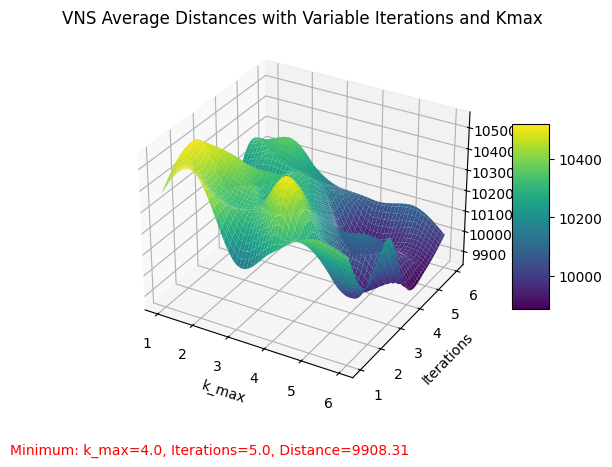

In [6]:
# Extracting k_max, iterations, and distances
k_max_plt = results_np[:, 0]
iter_plt = results_np[:, 1]
distance_plt = results_np[:, 2]

print(distance_plt)

# Find the minimum distance
min_distance = np.min(distance_plt)
min_index = np.argmin(distance_plt)
min_k_max = k_max_plt[min_index]
min_iter = iter_plt[min_index]

# Interpolation for a smoother surface
grid_x, grid_y = np.mgrid[min(k_max_plt):max(k_max_plt):100j, min(iter_plt):max(iter_plt):100j]
grid_z = griddata((k_max_plt, iter_plt), distance_plt, (grid_x, grid_y), method='cubic')

# Creating 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none')

# Highlighting the lowest distance
ax.scatter(min_k_max, min_iter, min_distance, color='r', s=30)  # Red color for visibility
# ax.text(min_k_max, min_iter, min_distance, f'Minimum: k_max={min_k_max}, Iterations={min_iter}, Distance={min_distance:.2f}', color='red')

# Labeling the axes
ax.set_xlabel('k_max')
ax.set_ylabel('Iterations')
ax.set_zlabel('Distance')

# Adding a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title('VNS Average Distances with Variable Iterations and Kmax')
plt.figtext(0, 0, f'Minimum: k_max={min_k_max}, Iterations={min_iter}, Distance={min_distance:.2f}', fontsize = 10, color='r') 

plt.show()

### Plot graph (k, i) per distance with standard deviation

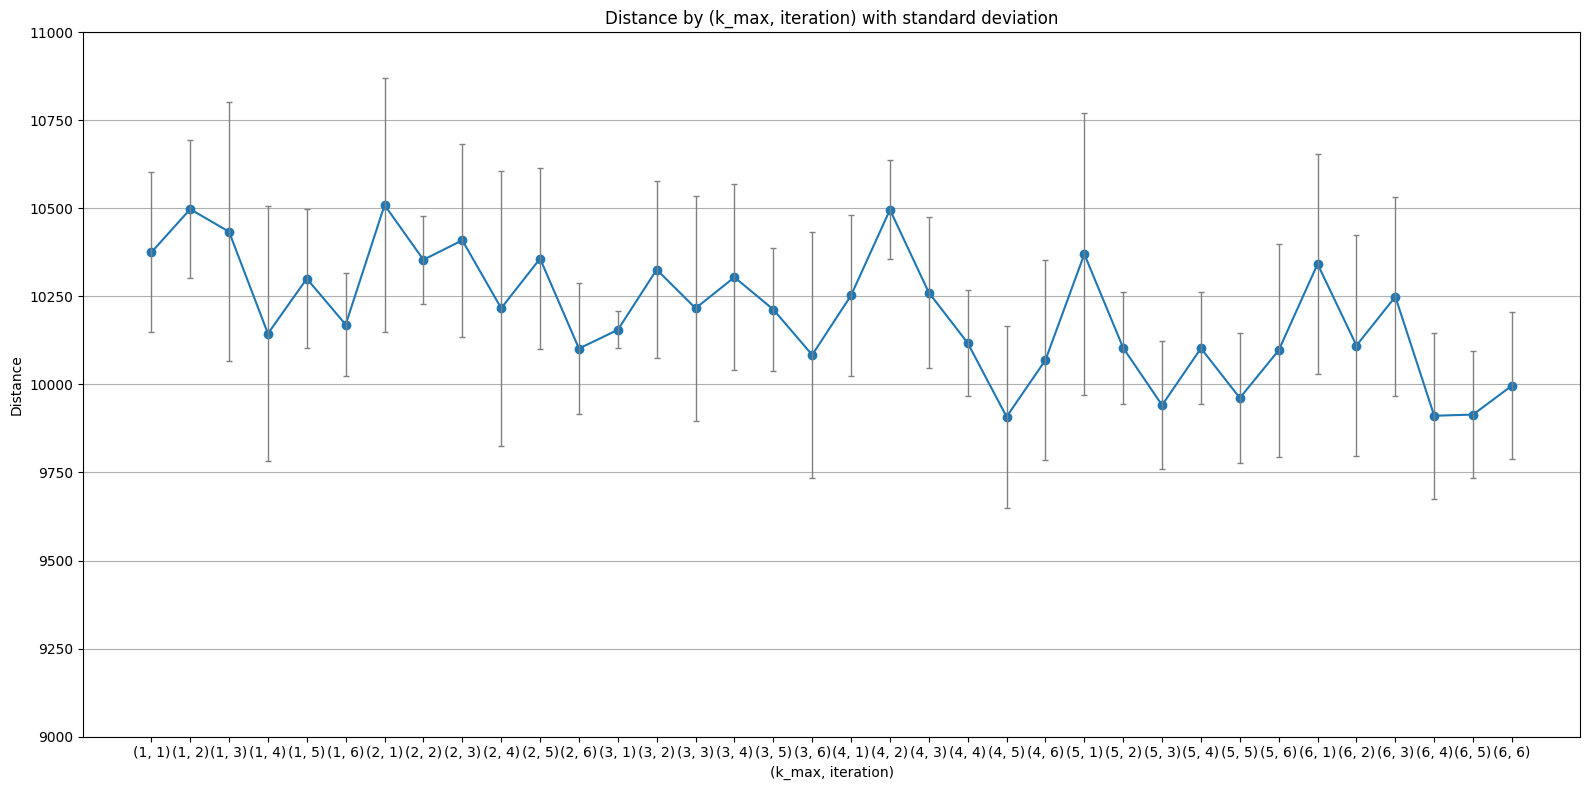

In [22]:
# Extract x and y values
x_values = [(k, i) for k in k_max_values for i in iterations]
y_values = [result[2] for result in results]
std_values = [result[3] for result in results]

# Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plotting connected points
ax.plot(range(len(x_values)), y_values, marker='o', linestyle='-')

# Error bars
for x, y, std in zip(range(len(x_values)), y_values, std_values):
    ax.errorbar(x, y, yerr=std, fmt='none', ecolor='gray', capsize=2, ls='-', lw=1)

# Setting labels and titles
ax.set_xlabel('(k_max, iteration)')
ax.set_ylabel('Distance')
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values)
ax.set_title('Distance by (k_max, iteration) with standard deviation')
ax.yaxis.grid(True)

# Adjusting y-axis scale
ax.set_ylim(9000, 11000)

plt.tight_layout()
plt.show()


### Plot graph (k, i) per execution time with standard deviation

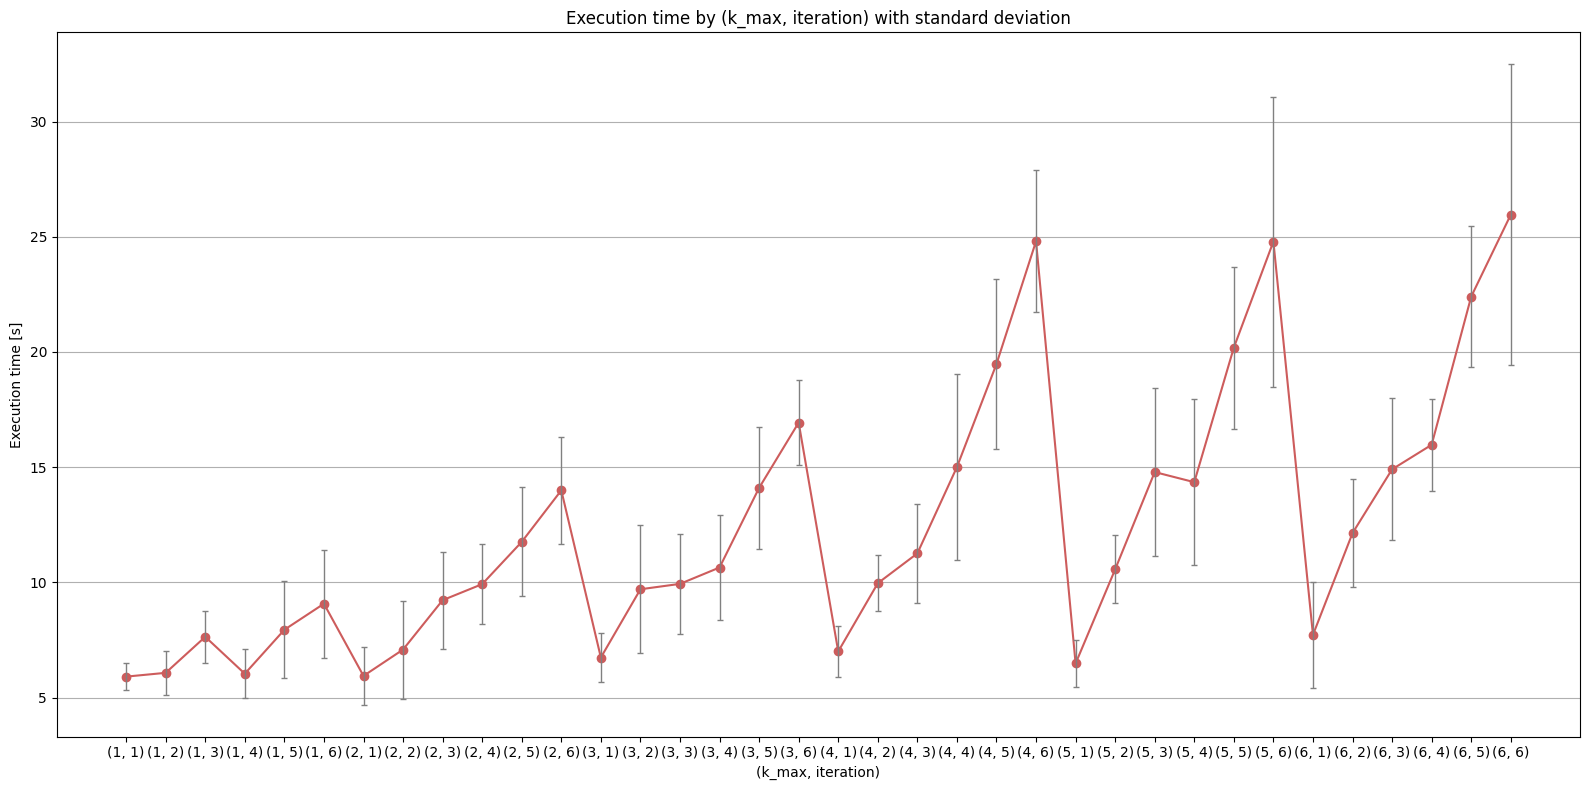

In [25]:

# Extract x and y values
x_values = [(k, i) for k in k_max_values for i in iterations]
y_values = [result[4] for result in results]
std_values = [result[5] for result in results]

# Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plotting connected points
ax.plot(range(len(x_values)), y_values, marker='o', linestyle='-', color='indianred')

# Error bars
for x, y, std in zip(range(len(x_values)), y_values, std_values):
    ax.errorbar(x, y, yerr=std, fmt='none', ecolor='gray', capsize=2, ls='-', lw=1)

# Setting labels and titles
ax.set_xlabel('(k_max, iteration)')
ax.set_ylabel('Execution time [s]')
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values)
ax.set_title('Execution time by (k_max, iteration) with standard deviation')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


In [2]:
# Read data from the text file
with open('data.txt', 'r') as file:
    data = file.readlines()

# Initialize lists to store values
best_values = []
worst_values = []
average_values = []
ideal_values = []
pairs = []
x_values = []

# Parse the data
for line in data:
    k_i = line.split(':')[0]
    x_values.append(k_i)
    parts = line.strip().split(': ')[1].split(', ')
    print(parts)
    pair = parts[0]
    pairs.append(pair)
    best_values.append(float(parts[0].split('=')[1]))
    worst_values.append(float(parts[1].split('=')[1]))
    average_values.append(float(parts[2].split('=')[1]))
    ideal_values.append(float(parts[3].split('=')[1]))

print(x_values)

# Plot the lines
plt.figure(figsize=(16, 6))
plt.plot(x_values, best_values, label='Best', color='g')
plt.plot(x_values, worst_values, label='Worst', color='r')
plt.plot(x_values, average_values, label='Average', color='orange')
plt.plot(x_values, ideal_values, label='Ideal', color='b')

# Add labels and title
plt.xlabel('(k, i)')
plt.xticks(rotation=45)
plt.ylabel('Distance')
plt.title('Performance Metrics')
ax.set_xticks(range(len(x_values)))
plt.legend()

# Show plot
plt.grid(True)
plt.show()


['Best=10102.970779743355', 'Worst=10767.598611248919', 'Average=10374.935626752987', 'Ideal=9352']
['Best=10215.108976418494', 'Worst=10817.266751677174', 'Average=10497.841225074479', 'Ideal=9352']
['Best=9776.37940388981', 'Worst=10827.434556809045', 'Average=10433.687596615113', 'Ideal=9352']
['Best=9822.78144466799', 'Worst=10825.006866112602', 'Average=10144.384932139432', 'Ideal=9352']
['Best=10034.234137820837', 'Worst=10608.516878250683', 'Average=10300.50695555072', 'Ideal=9352']
['Best=9952.831924125869', 'Worst=10399.316579560767', 'Average=10169.954583789402', 'Ideal=9352']
['Best=9871.201496307884', 'Worst=10992.354842775207', 'Average=10509.524847922883', 'Ideal=9352']
['Best=10190.938100373725', 'Worst=10567.313568062658', 'Average=10354.104051415386', 'Ideal=9352']
['Best=10069.065349777122', 'Worst=10865.703255005192', 'Average=10409.414694996172', 'Ideal=9352']
['Best=9748.08038986882', 'Worst=10849.197668399655', 'Average=10216.489282021545', 'Ideal=9352']
['Best=98

NameError: name 'plt' is not defined

In [1]:
# Calculate errors in percentage
best_errors = [((x - ideal) / ideal) * 100 for x, ideal in zip(best_values, ideal_values)]
worst_errors = [((x - ideal) / ideal) * 100 for x, ideal in zip(worst_values, ideal_values)]
average_errors = [((x - ideal) / ideal) * 100 for x, ideal in zip(average_values, ideal_values)]

# Plot the lines
plt.figure(figsize=(16, 6))
plt.plot(x_values, best_errors, label='Best Error', color='g')
plt.plot(x_values, worst_errors, label='Worst Error', color='r')
plt.plot(x_values, average_errors, label='Average Error', color='orange')

# Add labels and title
plt.xlabel('(k, i)')
plt.ylabel('Error (%)')
plt.title('Error Metrics')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.grid(True)
plt.show()


NameError: name 'best_values' is not defined